In [1]:
# Importing Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
import threadpoolctl
from threadpoolctl import threadpool_limits

In [2]:
# Step 1: Data Loading

In [3]:
# Define a custom function to handle bad lines
def handle_bad_lines(line):
    # Count the number of fields in the line
    num_fields = line.count(';') + 1
    # Check if the number of fields is expected
    if num_fields == 3:  # We expect three fields: User-ID, ISBN, and Book-Rating
        return line
    else:
        return None

# Load the CSV files into separate DataFrames
BX_Users = pd.read_csv("BX-Users.csv", sep=";", encoding="latin-1", engine="python", on_bad_lines=handle_bad_lines)
BX_Books = pd.read_csv("BX-Books.csv", sep=";", encoding="latin-1", engine="python", on_bad_lines=handle_bad_lines)

# Load BX_Book_Ratings DataFrame with skipping the header row
BX_Book_Ratings = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding="latin-1", engine="python", on_bad_lines=handle_bad_lines, skiprows=1, names=["User-ID", "ISBN", "Book-Rating"])

# Drop rows with invalid data (if any)
BX_Book_Ratings.dropna(subset=["User-ID", "ISBN", "Book-Rating"], inplace=True)

# Convert "User-ID" to integers
BX_Book_Ratings["User-ID"] = BX_Book_Ratings["User-ID"].astype(int)

# Extract ISBN from the loaded data
BX_Book_Ratings["ISBN"] = BX_Book_Ratings["ISBN"].str.strip('"')

# Display sample data from each DataFrame to ensure successful loading
print(BX_Users.head())
print(BX_Books.head())
print(BX_Book_Ratings.head())

   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author  Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                 2002     Oxford University Press   
1  Richard Bruce Wright                 2001       HarperFlamingo Canada   
2          Carlo D'Este                 1991 

In [4]:
# Step 2: Data Understanding and Exploration

In [5]:
# Check the structure and data types of each DataFrame
BX_Users.info()
BX_Books.info()
BX_Book_Ratings.info()

# Check for missing values
BX_Users.isnull().sum()
BX_Books.isnull().sum()
BX_Book_Ratings.isnull().sum()

# Explore the distribution of ratings in BX_Book_Ratings
BX_Book_Ratings["Book-Rating"].value_counts()

# Explore popular books, authors, and publishers in BX_Books
popular_books = BX_Book_Ratings["ISBN"].value_counts().head(10)
popular_authors = BX_Books["Book-Author"].value_counts().head(10)
popular_publishers = BX_Books["Publisher"].value_counts().head(10)

print("\nTop 10 Most Popular Books:")
print(popular_books)

print("\nTop 10 Most Popular Authors:")
print(popular_authors)

print("\nTop 10 Most Popular Publishers:")
print(popular_publishers)

# Analyze demographic information in BX_Users
BX_Users["Age"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278177 entries, 0 to 278176
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278177 non-null  int64  
 1   Location  278177 non-null  object 
 2   Age       167669 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270491 entries, 0 to 270490
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 270491 non-null  object
 1   Book-Title           270491 non-null  object
 2   Book-Author          270490 non-null  object
 3   Year-Of-Publication  270491 non-null  int64 
 4   Publisher            270489 non-null  object
 5   Image-URL-S          270491 non-null  object
 6   Image-URL-M          270491 non-null  object
 7   Image-URL-L          270491 non-null  object
dtypes: int64(1), 

count    167669.000000
mean         34.751797
std          14.430984
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

In [6]:
# Step 3: Data Preprocessing

In [7]:
# Remove irrelevant columns from BX_Users and BX_Books
BX_Users = BX_Users.drop(columns=["Location"])
BX_Books = BX_Books.drop(columns=["Image-URL-S", "Image-URL-M", "Image-URL-L"])

# Handle missing age values by filling with the mean age
mean_age = BX_Users["Age"].mean()
BX_Users["Age"] = BX_Users["Age"].fillna(mean_age)

# Convert age to numeric values
BX_Users["Age"] = pd.to_numeric(BX_Users["Age"], errors="coerce")

In [8]:
# Step 4: Exploratory Data Analysis (EDA)

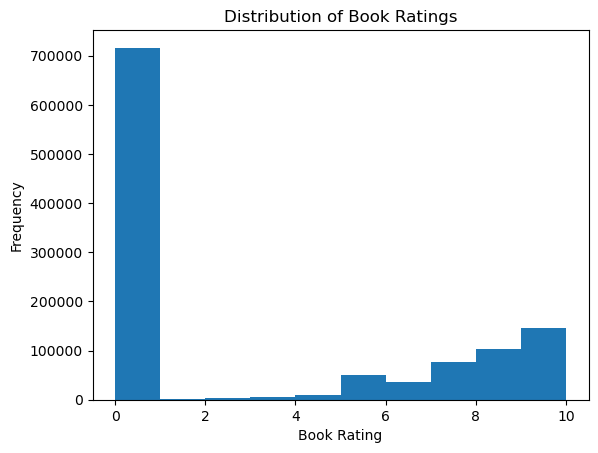

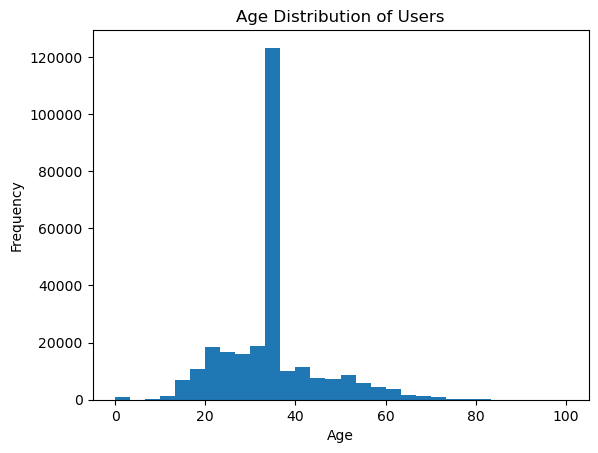

In [9]:
# Plot the distribution of book ratings in BX_Book_Ratings
plt.hist(BX_Book_Ratings["Book-Rating"], bins=10, range=(0, 10))
plt.xlabel("Book Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Book Ratings")
plt.show()

# Explore demographic information (age distribution, user locations, etc.)
# Age distribution of users
plt.hist(BX_Users["Age"], bins=30, range=(0, 100))
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution of Users")
plt.show()

In [10]:
# Step 5: Building a Recommendation System

In [11]:
# Create a Surprise Dataset from BX_Book_Ratings
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(BX_Book_Ratings[["User-ID", "ISBN", "Book-Rating"]], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the SVD (Singular Value Decomposition) algorithm on the training data
algo = SVD()
algo.fit(trainset)

# Predict ratings for the test set
predictions = algo.test(testset)

# Evaluate the recommendation system using RMSE (Root Mean Squared Error)
accuracy.rmse(predictions)

RMSE: 3.4991


3.4990989258440943

In [12]:
# Step 6: Personalized Book Recommendations

In [13]:
# Implement a function to provide personalized book recommendations based on user input
def get_personalized_recommendations(user_id, num_recommendations=5):
    # Get a list of books the user has not rated
    user_books = BX_Book_Ratings[BX_Book_Ratings["User-ID"] == user_id]["ISBN"]
    unrated_books = BX_Books[~BX_Books["ISBN"].isin(user_books)]
    
    # Predict ratings for unrated books
    predictions = []
    for isbn in unrated_books["ISBN"]:
        prediction = algo.predict(user_id, isbn)
        predictions.append((isbn, prediction.est))
    
    # Sort predictions by rating in descending order
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:num_recommendations]
    
    # Return the top recommended books
    return recommendations

# Example usage:
user_id = 100
recommended_books = get_personalized_recommendations(user_id)
print(recommended_books)

[('1844262553', 6.649078439104596), ('0590353403', 6.279109538383311), ('0156528207', 6.020008129741474), ('0615116426', 5.94066276593406), ('0064440508', 5.72583774294977)]


/Users/kamiluck/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kamiluck/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kamiluck/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kamiluck/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

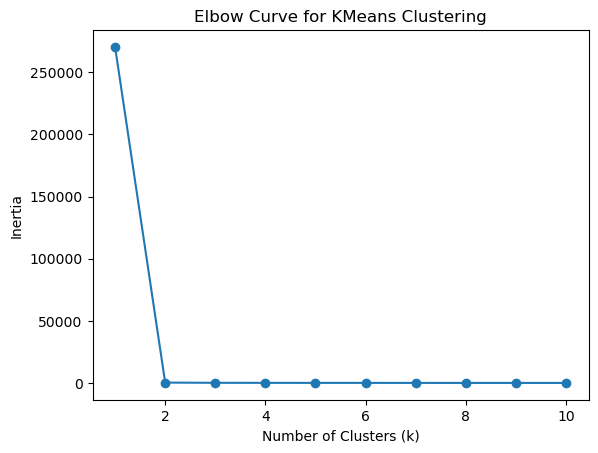

/Users/kamiluck/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Cluster 1 - Number of Books: 265880
0                                  Classical Mythology
1                                         Clara Callan
2                                 Decision in Normandy
3    Flu: The Story of the Great Influenza Pandemic...
4                               The Mummies of Urumchi
Name: Book-Title, dtype: object
0      Mark P. O. Morford
1    Richard Bruce Wright
2            Carlo D'Este
3        Gina Bari Kolata
4         E. J. W. Barber
Name: Book-Author, dtype: object
0    2002
1    2001
2    1991
3    1999
4    1999
Name: Year-Of-Publication, dtype: int64

Cluster 2 - Number of Books: 4611
176                                     Kabale Und Liebe
188                              Die Liebe in Den Zelten
288                          Poisonwood Bible Edition Uk
351         Herr Der Fliegen (Fiction, Poetry and Drama)
542    Biblioteca Universale Rizzoli: Sulla Sponda De...
Name: Book-Title, dtype: object
176                  Schiller
188    Gabriel Garcia

In [15]:
# Step 7: Book Clustering (Optional)

# Perform book clustering using relevant attributes from BX_Books
# (e.g., book genres, book titles, etc.)

# For example, we can use KMeans clustering based on the Year-Of-Publication and other numeric attributes

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant attributes for clustering
selected_attributes = ["Year-Of-Publication"]

# Remove rows with missing values for selected attributes
selected_data = BX_Books[selected_attributes].dropna()

# Standardize the data before clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

# Determine the optimal number of clusters using the elbow method
inertia_values = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve to identify the optimal number of clusters
plt.plot(k_range, inertia_values, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Curve for KMeans Clustering")
plt.show()

# Based on the elbow curve, choose the optimal number of clusters (k) and perform KMeans clustering
k_optimal = 2
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the DataFrame
selected_data["Cluster"] = clusters

# Merge cluster labels back to the original DataFrame
BX_Books_clustered = BX_Books.copy()
BX_Books_clustered["Cluster"] = selected_data["Cluster"]

# Explore the characteristics of each book cluster
for cluster_id in range(k_optimal):
    cluster_books = BX_Books_clustered[BX_Books_clustered["Cluster"] == cluster_id]
    print(f"\nCluster {cluster_id + 1} - Number of Books: {len(cluster_books)}")
    print(cluster_books["Book-Title"].head())
    print(cluster_books["Book-Author"].head())
    print(cluster_books["Year-Of-Publication"].head())